In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import lasso_path
import shutil

In [4]:
os.chdir("/media/feike/14Tdisk1/ZHY") 
print(os.getcwd())

/media/feike/14Tdisk1/ZHY


In [3]:
output_dir = "./output/model_feature_selection/Lasso" 
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

In [4]:
all_files = [] 
for root, dirs, files in os.walk("./output/model_feature_selection/Lasso/relevance_selection_2"): 
    for file in files:
        if ("p0.05_FS" in file) and (file.endswith('.xlsx') or file.endswith('.csv')): 
            all_files.append(os.path.join(root, file))

/home/feike/miniconda3/envs/radiomics/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005596902665913062, tolerance: 0.0005400000000000001
  model = cd_fast.enet_coordinate_descent_gram(
/home/feike/miniconda3/envs/radiomics/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005573051177814037, tolerance: 0.0005400000000000001
  model = cd_fast.enet_coordinate_descent_gram(
/home/feike/miniconda3/envs/radiomics/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005590740589100918, tolerance: 0.0005400000000000001
  model = cd_fast.enet_coordinate_descent_gram(
/

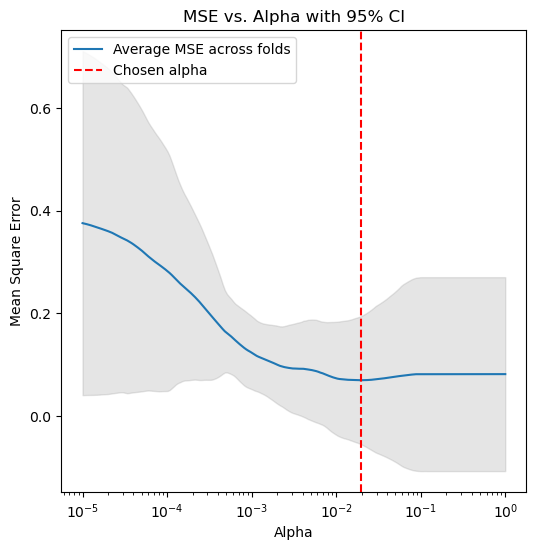

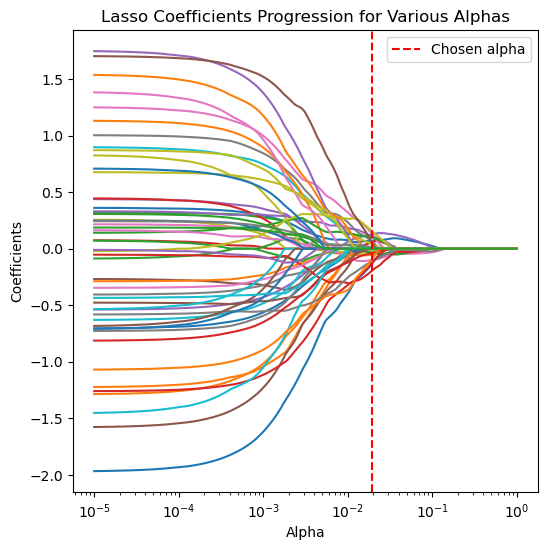

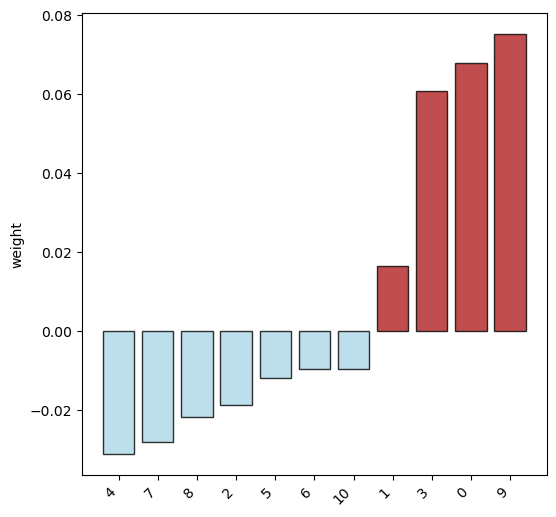

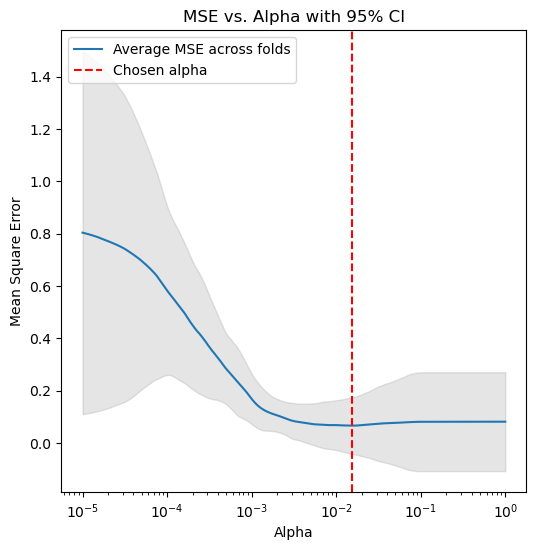

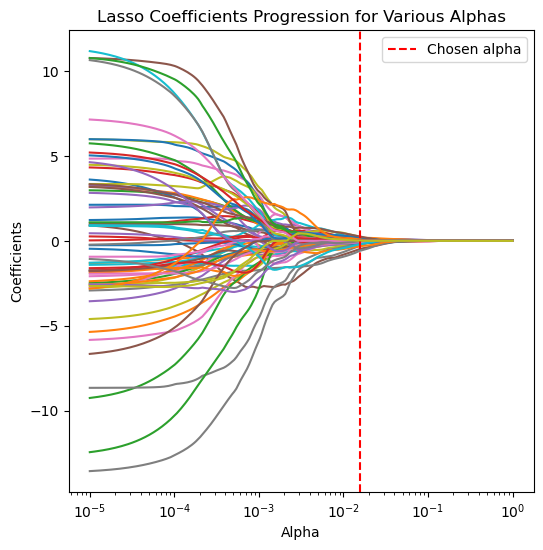

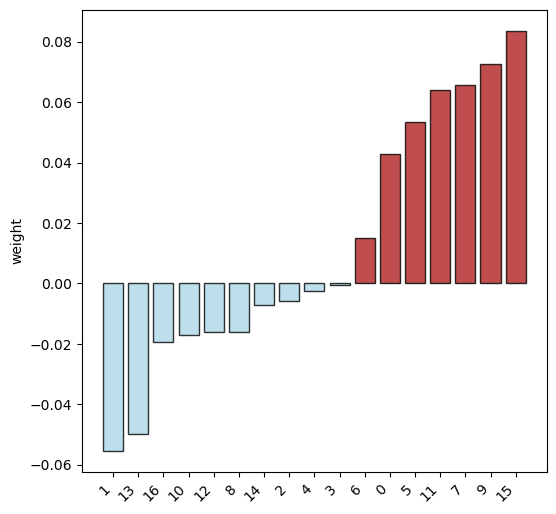

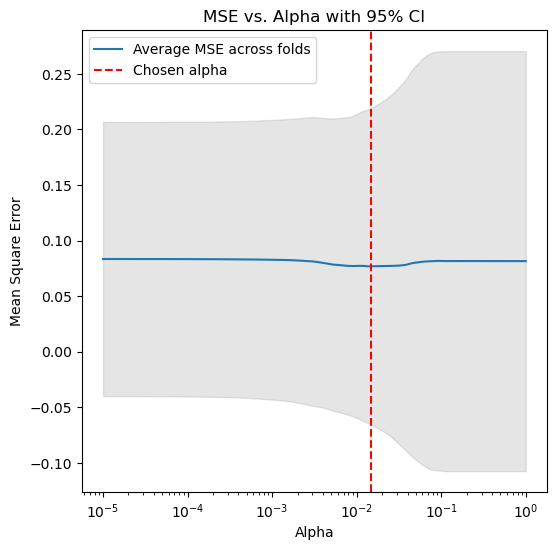

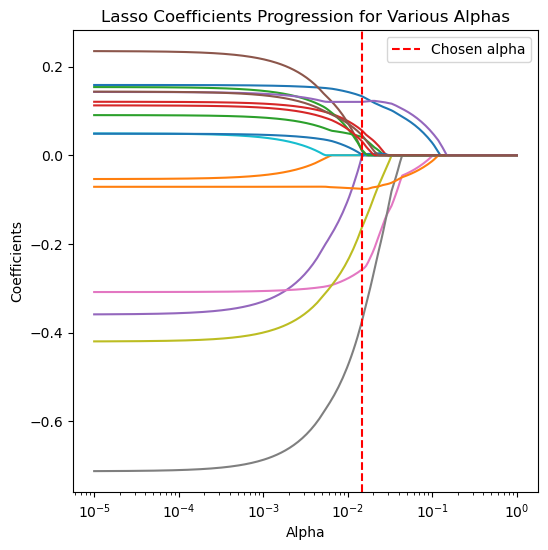

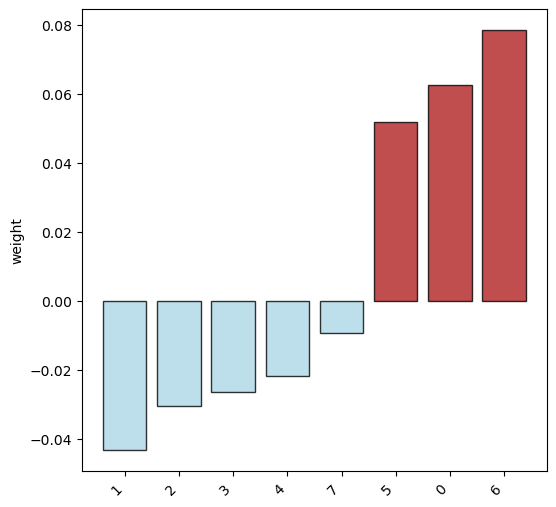

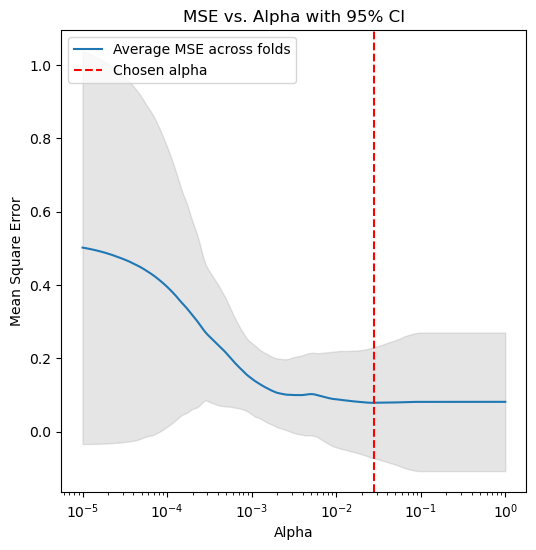

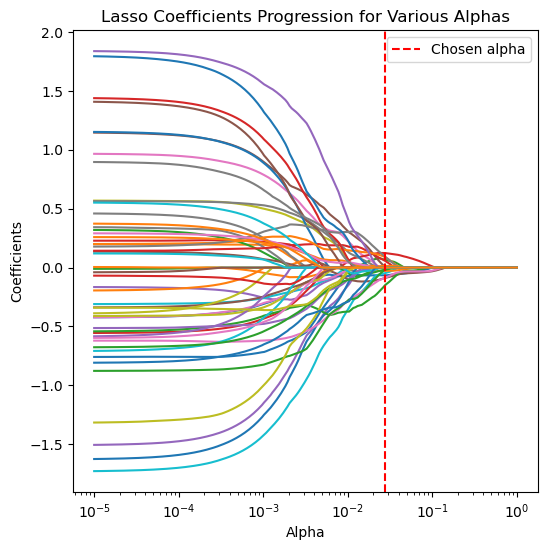

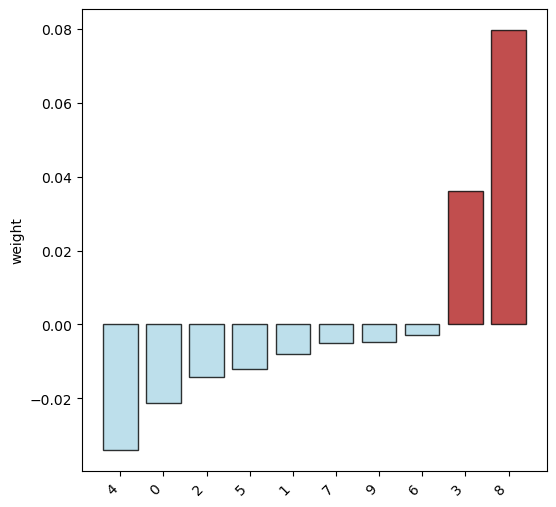

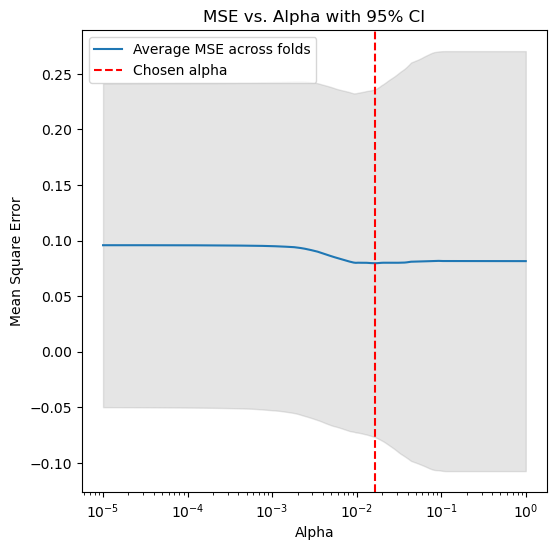

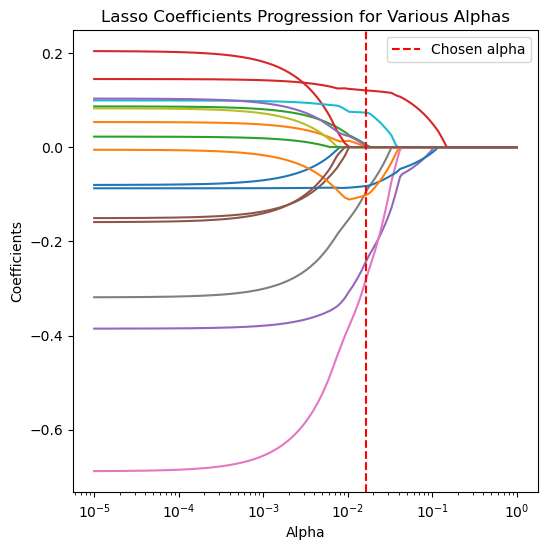

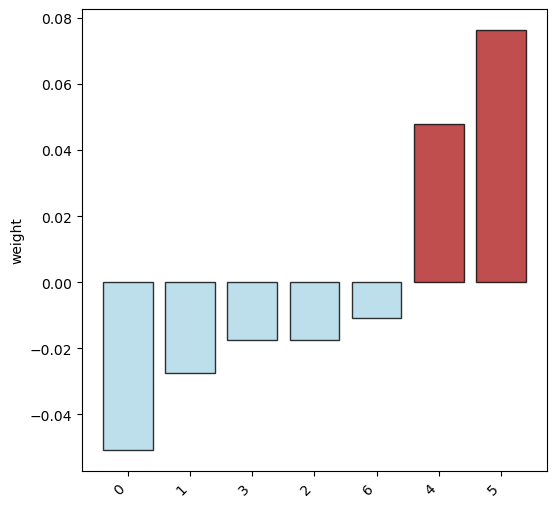

In [5]:
for file_path in all_files:
    file_name_without_ext = os.path.splitext(os.path.basename(file_path))[0]
    df = pd.read_excel(file_path) if file_path.endswith('.xlsx') else pd.read_csv(file_path)
    X = df.iloc[:, 2:].values 
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    y = df['Group']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    alphas = np.exp(np.linspace(np.log(1e-5), np.log(1), 200)) 
    lasso = LassoCV(alphas=alphas, cv=10, random_state=0)
    lasso.fit(X_train, y_train)

    mse_mean = lasso.mse_path_.mean(axis=-1)
    mse_std = lasso.mse_path_.std(axis=-1)
    plt.figure(figsize=(6, 6))
    plt.semilogx(lasso.alphas_, mse_mean, label="Average MSE across folds")  
    plt.fill_between(lasso.alphas_, mse_mean - 1.96 * mse_std, mse_mean + 1.96 * mse_std, color='gray', alpha=0.2)
    plt.axvline(lasso.alpha_, linestyle="--", color="red", label="Chosen alpha")
    plt.xlabel("Alpha")  
    plt.ylabel("Mean Square Error")
    plt.title("MSE vs. Alpha with 95% CI")
    plt.legend()
    plt.savefig(os.path.join(output_dir, f"{file_name_without_ext}_cv_with_CI.pdf"))
    alphas_lasso, coefs_lasso, _ = lasso_path(X_train, y_train, alphas=alphas)
    plt.figure(figsize=(6, 6))
    plt.semilogx(alphas_lasso, coefs_lasso.T) 
    plt.axvline(lasso.alpha_, linestyle="--", color="red", label="Chosen alpha")
    plt.ylabel('Coefficients')
    plt.xlabel('Alpha')  
    plt.title('Lasso Coefficients Progression for Various Alphas')
    plt.legend()
    plt.savefig(os.path.join(output_dir, f"{file_name_without_ext}_lam.pdf"))

    feature_names = df.columns[2:]
    non_zero_indices = np.where(lasso.coef_ != 0)[0]
    non_zero_coefs = lasso.coef_[non_zero_indices]
    non_zero_feature_names = feature_names[non_zero_indices]
    coeff_df = pd.DataFrame({
        'Feature Name': non_zero_feature_names,
        'Coefficient': non_zero_coefs
    })
    coeff_df.to_csv(os.path.join(output_dir, f"{file_name_without_ext}_Lasso-filtered_feature_coefficients.csv"), index=False)
    sorted_indices = np.argsort(non_zero_coefs)
    sorted_coefs = non_zero_coefs[sorted_indices]
    x_values = np.arange(len(sorted_coefs))
    plt.figure(figsize=(6, 6))
    plt.bar(x_values, sorted_coefs, color=np.where(sorted_coefs > 0, 'firebrick', 'lightblue'), edgecolor='black', alpha=0.8)
    plt.xticks(x_values, sorted_indices, rotation=45, ha='right', va='top')
    plt.ylabel('weight')
    plt.savefig(os.path.join(output_dir, f"{file_name_without_ext}_Lasso-filtered_feature_coefficients_histogram.pdf"))
    non_zero_indices = np.where(lasso.coef_ != 0)[0]
    selected_data = df.iloc[:, [0, 1] + list(non_zero_indices + 2)]
    selected_data.to_csv(os.path.join(output_dir, f"{file_name_without_ext}_Lasso-feature_matrix.csv"), index=False)

In [ ]:
# 复制输出文件

In [13]:
# 定义源路径和目标路径
source_dir = './output/model_feature_selection/Lasso'
target_dir = './output/model_feature_selection/use_feature'

In [10]:
# 确保目标路径存在
os.makedirs(target_path, exist_ok=True)

In [17]:
# 遍历源文件夹中的所有文件（不包括子文件夹内的文件）
for filename in os.listdir(source_dir):
    file_path = os.path.join(source_dir, filename)
    
    # 检查是否是文件且文件名中包含"Lasso-feature_matrix"
    if os.path.isfile(file_path) and "Lasso-feature_matrix" in filename:
        # 构建目标文件的完整路径
        target_path = os.path.join(target_dir, filename)
        # 移动文件
        shutil.copy(file_path, target_path)
        print(f'文件 {filename} 已复制到 {target_dir}')

文件 cl_dl_features_train_t_test_p0.05_FS_Lasso-feature_matrix.csv 已移动到 ./output/model_feature_selection/use_feature
文件 cl_ml_dl_features_train_t_test_p0.05_FS_Lasso-feature_matrix.csv 已移动到 ./output/model_feature_selection/use_feature
文件 cl_ml_features_train_t_test_p0.05_FS_Lasso-feature_matrix.csv 已移动到 ./output/model_feature_selection/use_feature
文件 dl_features_train_t_test_p0.05_FS_Lasso-feature_matrix.csv 已移动到 ./output/model_feature_selection/use_feature
文件 ml_features_train_t_test_p0.05_FS_Lasso-feature_matrix.csv 已移动到 ./output/model_feature_selection/use_feature
